# Self-Exciting Behavior and Detecting the End of Price Trends

In this video I show a method I use to exit trades for momentum/trend following strategies. It is the Hawkes Process, a useful tool for algorithmic traders to know. The Hawkes Process is a type of self-exciting process and can be used to handle the self-exciting behavior found in volume/volatility. In this video we apply it to measure of volatility, the range of candles (high - low). Often major trends exhibit higher volatility. Trends often end around the same time that the volatility has dispersed. I show a simple trading strategy using the hawkes process that has decent performance and fairly high win rates for a momentum based  trading strategy. A python implementation is shown for the indicator and the strategy.

* Tutorial: [Self-Exciting Behavior and Detecting the End of Price Trends | Algorithmic Trading Strategy](https://www.youtube.com/watch?v=wdsiZBIhAFw)
* Full Code: https://github.com/neurotrader888/VolatilityHawkes

Links

- https://en.wikipedia.org/wiki/Point_process
- https://en.wikipedia.org/wiki/Hawkes_process
- https://en.wikipedia.org/wiki/Volatility_clustering

- https://github.com/tr8dr/tseries-patterns/blob/master/docs/HawkesBSI.md
- https://tr8dr.github.io/BuySellImbalance/
- https://tr8dr.github.io/

In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

In [2]:
def plot_two_axes(series1, *ex_series):
    plt.style.use('dark_background')
    ax = series1.plot(color='green')
    ax2 = ax.twinx()
    for i, series in enumerate(ex_series):
        series.plot(ax=ax2, alpha=0.5)
    #plt.show()

def hawkes_process(data: pd.Series, kappa: float):
    assert(kappa > 0.0)
    alpha = np.exp(-kappa)
    arr = data.to_numpy()
    output = np.zeros(len(data))
    output[:] = np.nan
    for i in range(1, len(data)):
        if np.isnan(output[i - 1]):
            output[i] = arr[i]
        else:
            output[i] = output[i - 1] * alpha + arr[i]
    return pd.Series(output, index=data.index) * kappa

def vol_signal(close: pd.Series, vol_hawkes: pd.Series, lookback:int):
    signal = np.zeros(len(close))
    q05 = vol_hawkes.rolling(lookback).quantile(0.05)
    q95 = vol_hawkes.rolling(lookback).quantile(0.95)
    
    last_below = -1
    curr_sig = 0

    for i in range(len(signal)):
        if vol_hawkes.iloc[i] < q05.iloc[i]:
            last_below = i
            curr_sig = 0

        if vol_hawkes.iloc[i] > q95.iloc[i] \
           and vol_hawkes.iloc[i - 1] <= q95.iloc[i - 1] \
           and last_below > 0 :
            
            change = close.iloc[i] - close.iloc[last_below]
            if change > 0.0:
                curr_sig = 1
            else:
                curr_sig = -1
        signal[i] = curr_sig

    return signal

def get_trades_from_signal(data: pd.DataFrame, signal: np.array):
    # Gets trade entry and exit times from a signal
    # that has values of -1, 0, 1. Denoting short,flat,and long.
    # No position sizing.

    long_trades = []
    short_trades = []

    close_arr = data['close'].to_numpy()
    last_sig = 0.0
    open_trade = None
    idx = data.index
    for i in range(len(data)):
        if signal[i] == 1.0 and last_sig != 1.0: # Long entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                short_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        if signal[i] == -1.0  and last_sig != -1.0: # Short entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                long_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        
        if signal[i] == 0.0 and last_sig == -1.0: # Short exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            short_trades.append(open_trade)
            open_trade = None

        if signal[i] == 0.0  and last_sig == 1.0: # Long exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            long_trades.append(open_trade)
            open_trade = None

        last_sig = signal[i]

    long_trades = pd.DataFrame(long_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])
    short_trades = pd.DataFrame(short_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])

    long_trades['percent'] = (long_trades['exit_price'] - long_trades['entry_price']) / long_trades['entry_price']
    short_trades['percent'] = -1 * (short_trades['exit_price'] - short_trades['entry_price']) / short_trades['entry_price']
    long_trades = long_trades.set_index('entry_time')
    short_trades = short_trades.set_index('entry_time')
    return long_trades, short_trades

In [3]:
# Load data
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')

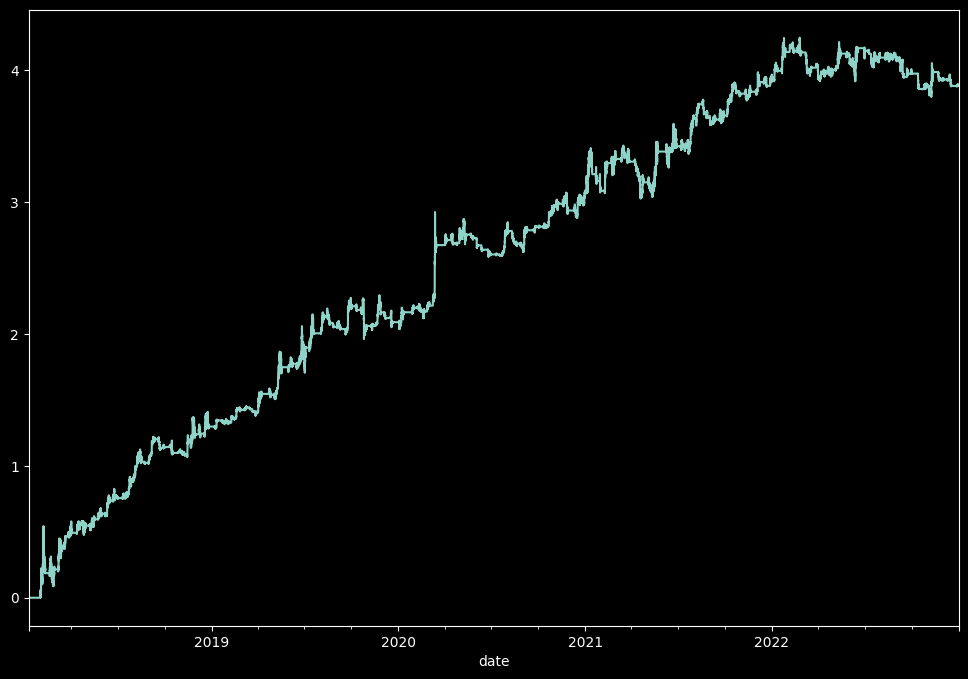

In [4]:
# Normalize volume
norm_lookback = 336
data['atr'] = ta.atr(np.log(data['high']), np.log(data['low']), np.log(data['close']), norm_lookback) 
data['norm_range'] = (np.log(data['high']) - np.log(data['low'])) / data['atr']
#plot_two_axes(np.log(data['close']), data['norm_range'])

data['v_hawk'] = hawkes_process(data['norm_range'], 0.1)
data['sig'] = vol_signal(data['close'], data['v_hawk'], 168)

data['next_return'] = np.log(data['close']).diff().shift(-1)
data['signal_return'] = data['sig'] * data['next_return']
win_returns = data[data['signal_return'] > 0]['signal_return'].sum()
lose_returns = data[data['signal_return'] < 0]['signal_return'].abs().sum()
signal_pf = win_returns / lose_returns
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))
data['signal_return'].cumsum().plot()
plt.show()

In [5]:
long_trades, short_trades = get_trades_from_signal(data, data['sig'].to_numpy())
long_win_rate = len(long_trades[long_trades['percent'] > 0]) / len(long_trades)
short_win_rate = len(short_trades[short_trades['percent'] > 0]) / len(short_trades)
long_average = long_trades['percent'].mean()
short_average = short_trades['percent'].mean()
time_in_market = len(data[data['sig'] != 0.0]) / len(data)

print("Profit Factor", signal_pf)
print("Long Win Rate", long_win_rate) 
print("Long Average", long_average) 
print("Short Win Rate", short_win_rate) 
print("Short Average", short_average)
print("Time In Market", time_in_market)

Profit Factor 1.0681024788354196
Long Win Rate 0.5842696629213483
Long Average 0.028824307425106954
Short Win Rate 0.4909090909090909
Short Average 0.011315655663682962
Time In Market 0.5092316855270994


In [6]:
# Code for the heatmap
kappa_vals = [0.5, 0.25, 0.1, 0.05, 0.01]
lookback_vals = [24, 48, 96, 168, 336] 
pf_df = pd.DataFrame(index=lookback_vals, columns=kappa_vals)

for lb in tqdm(lookback_vals):
    for k in kappa_vals:
        data['v_hawk'] = hawkes_process(data['norm_range'], k)
        data['sig'] = vol_signal(data['close'], data['v_hawk'], lb)

        data['next_return'] = np.log(data['close']).diff().shift(-1)
        data['signal_return'] = data['sig'] * data['next_return']
        win_returns = data[data['signal_return'] > 0]['signal_return'].sum()
        lose_returns = data[data['signal_return'] < 0]['signal_return'].abs().sum()
        signal_pf = win_returns / lose_returns

        pf_df.loc[lb, k] = float(signal_pf)

100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.74s/it]


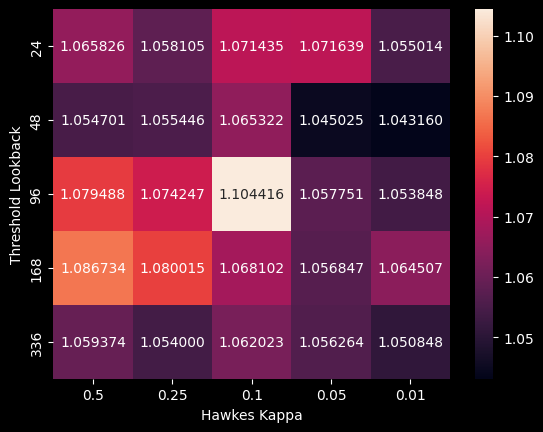

In [7]:
plt.style.use('dark_background')
pf_df = pf_df.astype(float)
sns.heatmap(pf_df, annot=True, fmt='f')
plt.xlabel('Hawkes Kappa')
plt.ylabel('Threshold Lookback')
plt.show()